## Preparation of the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

In [2]:
IMAGE_SIZE = 224

img_dir = "../input/car-plate-detection/images"  
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [3]:
# We create the variable y containing all the bounding boxe annotations (label). 
# Before that, we will have to resize the annotations so that it fits the new size of the images (224*224).  
from lxml import etree
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    tree = etree.parse(i)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE) 
        y.append([int(xmax), int(ymax), int(xmin), int(ymin)])
        break

# checking output        
print(y[0])

[187, 144, 101, 104]


In [4]:
np.array(X).shape
np.array(y).shape

(433, 4)

## Some Images in dataset

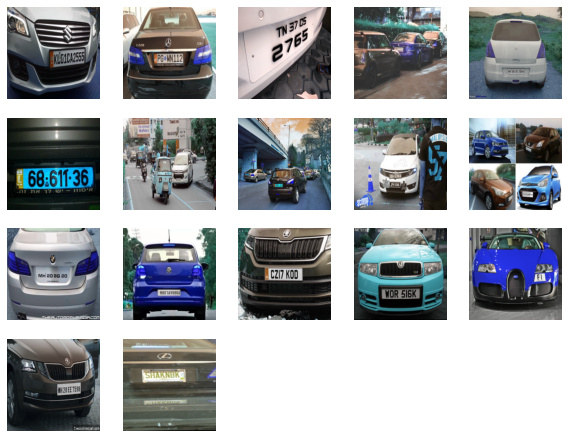

In [5]:
#plotting some images from dataset
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

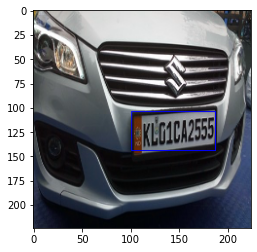

In [6]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


## prepare the data for the CNN :

In [7]:
#Transforming in array
X=np.array(X)
y=np.array(y)

#Renormalisation
X = X / 255
y = y / 255

## Splitting Data

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_test.shape

(44, 224, 224, 3)

## Convolutionnal Neural Network for Plate detection

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16

In [10]:
# Create the model
model = Sequential()
wts='../input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
model.add(VGG16(weights=wts, include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
____________________________________

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=65, batch_size=32, verbose=1)

# Testing the model
scores = model.evaluate(X_test, y_test)
print("Score : %.2f%%" % (scores[1]*100))

Epoch 1/65
13/13 [==============================] - 2s 131ms/step - loss: 0.1100 - accuracy: 0.5039 - val_loss: 0.0853 - val_accuracy: 0.5909
Epoch 2/65
13/13 [==============================] - 1s 69ms/step - loss: 0.0773 - accuracy: 0.5476 - val_loss: 0.0676 - val_accuracy: 0.2045
Epoch 3/65
13/13 [==============================] - 1s 66ms/step - loss: 0.0276 - accuracy: 0.5656 - val_loss: 0.0176 - val_accuracy: 0.4091
Epoch 4/65
13/13 [==============================] - 1s 67ms/step - loss: 0.0119 - accuracy: 0.6658 - val_loss: 0.0080 - val_accuracy: 0.7500
Epoch 5/65
13/13 [==============================] - 1s 66ms/step - loss: 0.0057 - accuracy: 0.7712 - val_loss: 0.0076 - val_accuracy: 0.8636
Epoch 6/65
13/13 [==============================] - 1s 67ms/step - loss: 0.0039 - accuracy: 0.7995 - val_loss: 0.0061 - val_accuracy: 0.5909
Epoch 7/65
13/13 [==============================] - 1s 68ms/step - loss: 0.0026 - accuracy: 0.8201 - val_loss: 0.0054 - val_accuracy: 0.8182
Epoch 8/65
1

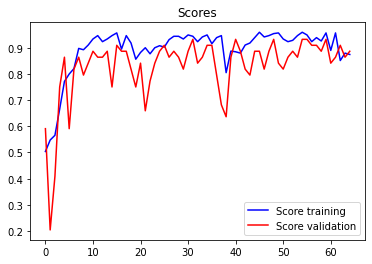

In [12]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score training')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

plot_scores(train)

## Object Detection 

In [13]:
y_cnn = model.predict(X_test)
y_cnn.shape

(44, 4)

We can see how our model localize license plates on our testing set :

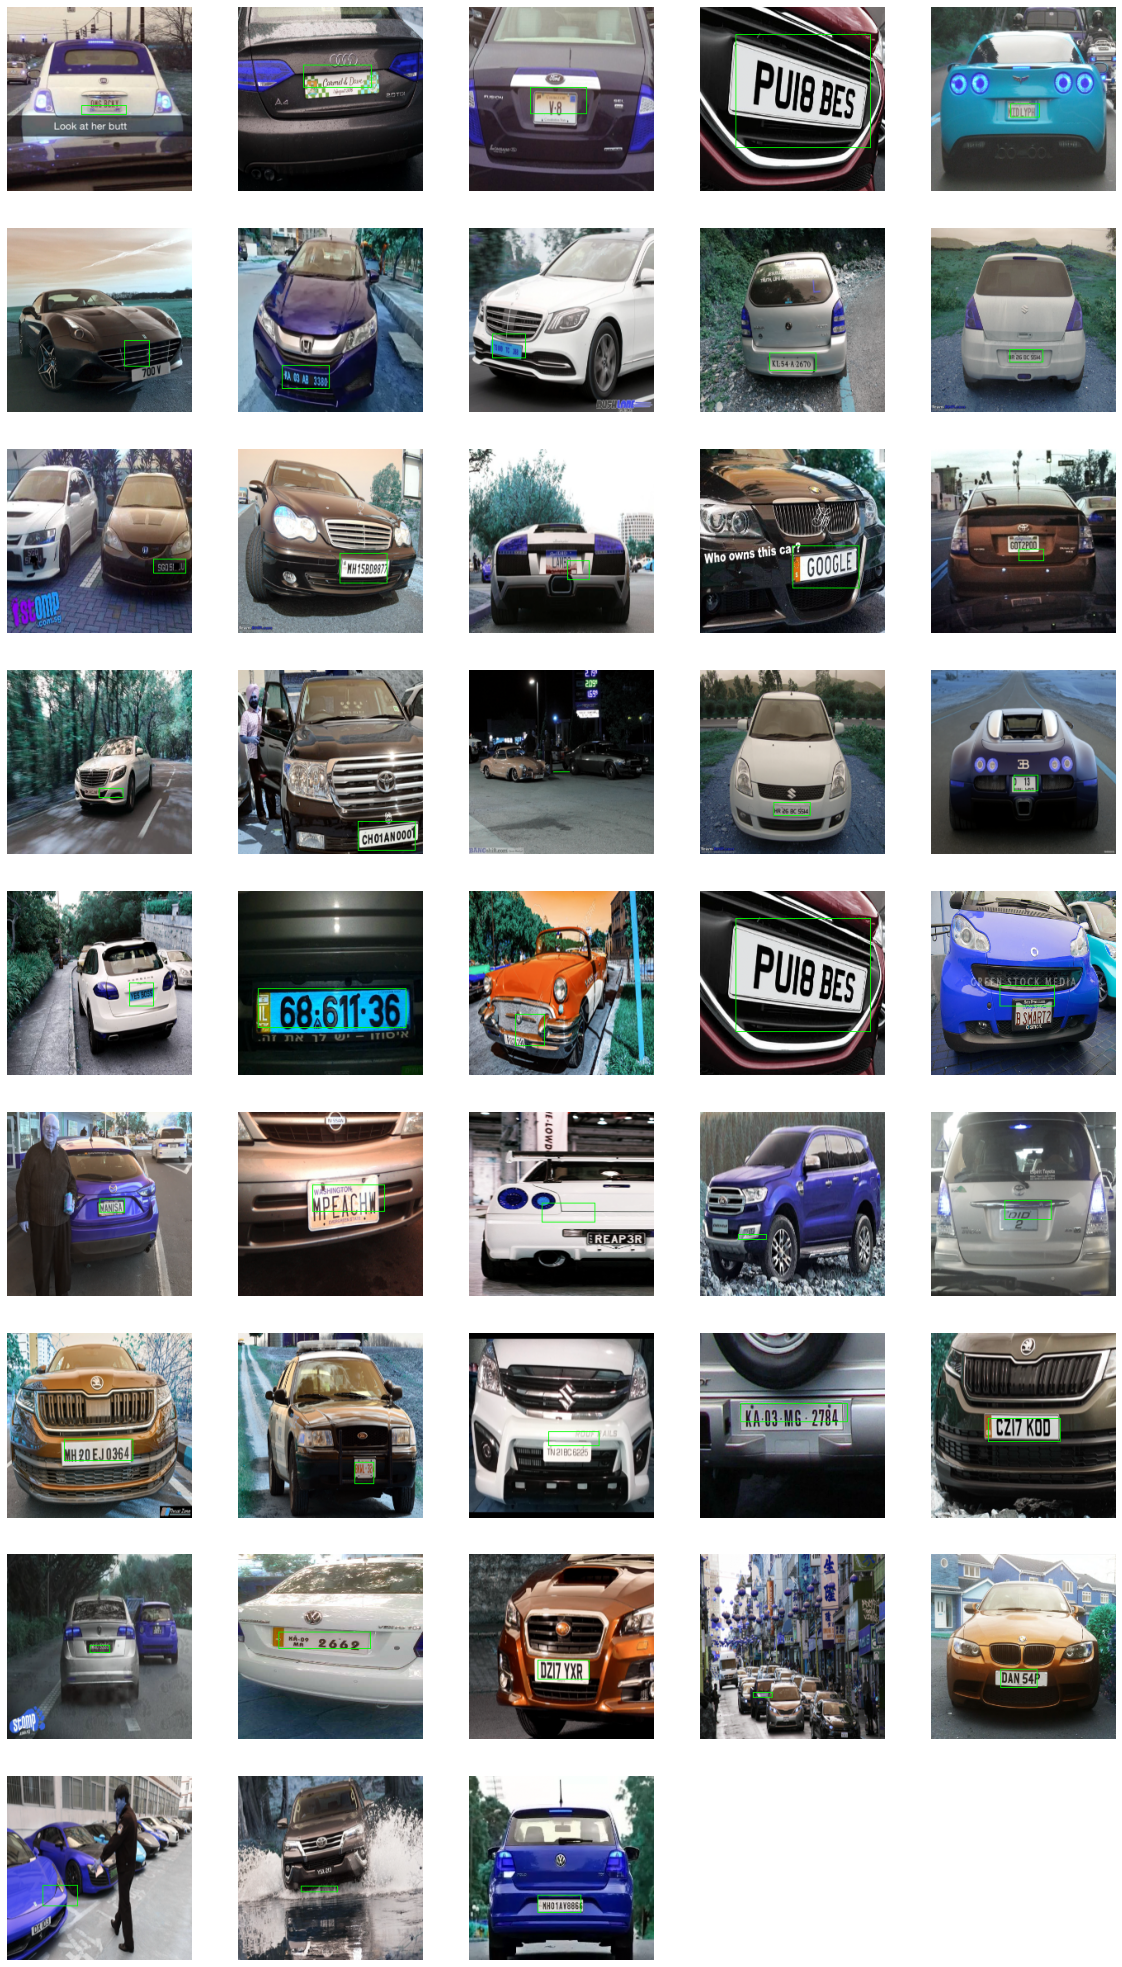

In [14]:
def plotFigures(X_test, y_cnn):
    plt.figure(figsize=(20,40))
    for i in range(0,43) :
        plt.subplot(10,5,i+1)
        plt.axis('off')
        ny = y_cnn[i]*255
        image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
        plt.imshow(image)

# Plotting test images.
plotFigures(X_test, y_cnn)


In [15]:
model.save('license_plate_detector.h5')
# detector = load_model('license_plate_detector.h5')
# detector

## **Character Segmentation**

In [16]:
from matplotlib import pyplot as plt

# find characters from ing
def find_characters(image) :
    
    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[1]
    LP_HEIGHT = img_binary_lp.shape[0]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)
    print(img_binary_lp.shape)
    # Get contours within cropped license plate
    
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img_binary_lp.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = LP_WIDTH/12
    upper_width = LP_WIDTH/4
    lower_height = LP_HEIGHT/7
    upper_height = LP_HEIGHT
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    #print(lower_width, '-', upper_width,', ' ,lower_height, '-', upper_height)
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #print(intWidth, intHeight)
        # checking the dimensions of the contour to filter out the characters by contour's size
        # if True:
        if intWidth >= lower_width and intWidth <= upper_width and intHeight >= lower_height and intHeight <= upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img_binary_lp[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            
            # invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    plt.title('Predicted Segments')
    plt.show()
    
    # function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    
    #store characters in sorted ordeer of x coordinate
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    
    char_list = np.array(img_res_copy)

    return char_list



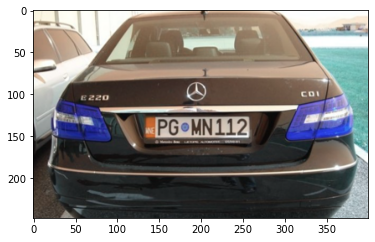

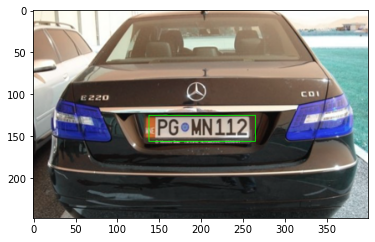

138 125 265 156
(31, 127, 3)


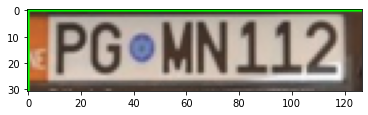

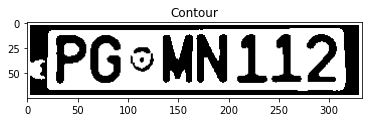

(75, 333)


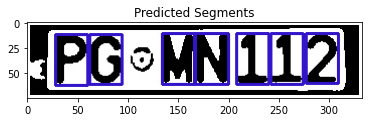

(7, 44, 24)


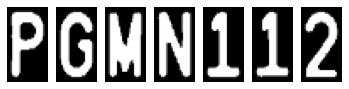

In [17]:
def getLicensePlateNumber(im = 'Cars250'):
    # wts='license_plate_detector.h5'
    # model = VGG16(weights=wts, include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    # !ls ../input/car-plate-detection/images
    # im = 'Cars250'
    im_path = '../input/car-plate-detection/images/' + im + '.png'
    xml_path = '../input/car-plate-detection/annotations/' + im + '.xml'
    image = cv2.imread(im_path)
    # image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
    plt.imshow(image)
    plt.show()
    img = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    inp = [] 
    inp.append(np.array(img))
    inp = np.array(inp)
    inp = inp/255

    pred = model.predict(inp)

    # xml_file = '../input/car-plate-detection/annotations/Cars318.xml'
    xml_file = xml_path
    # from lxml import etree
    tree = etree.parse(xml_file)
    wd = 0
    ht = 0
    for dim in tree.xpath("size"):
        wd = int(dim.xpath("width")[0].text)
        ht = int(dim.xpath("height")[0].text)              

    ny = pred[0]*255
    topleft = (int(ny[0]*(wd/IMAGE_SIZE)),int(ny[1]*(ht/IMAGE_SIZE)))
    bottomright = (int(ny[2]*(wd/IMAGE_SIZE)),int(ny[3]*(ht/IMAGE_SIZE)))
    img = cv2.rectangle(image, bottomright, topleft,(0, 255, 0))
    plt.imshow(img)
    plt.show()


    x2 = int(ny[0]*(wd/IMAGE_SIZE))
    y2 = int(ny[1]*(ht/IMAGE_SIZE))
    x1 = int(ny[2]*(wd/IMAGE_SIZE))
    y1 = int(ny[3]*(ht/IMAGE_SIZE))

    print(x1, y1, x2, y2)
    img_cropped = img[y1:y2, x1:x2]
    print(img_cropped.shape)
    plt.imshow(img_cropped)
    plt.show()
    # char=segment_characters(cropped)

    chars = find_characters(img_cropped)
    print(chars.shape)
    for i in range(len(chars)):
        plt.subplot(1, len(chars), i+1)
        plt.imshow(chars[i], cmap='gray')
        plt.axis('off')
    plt.show()
    return chars
    
chars = getLicensePlateNumber('Cars250')

## CNN Model for char recognition

In [18]:
model_char = Sequential()
model_char.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model_char.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model_char.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model_char.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model_char.add(MaxPooling2D(pool_size=(4, 4)))
model_char.add(Dropout(0.4))
model_char.add(Flatten())
model_char.add(Dense(128, activation='relu'))
model_char.add(Dense(36, activation='softmax'))

model_char.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

model_char.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)             

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '../input/chardata/data'

train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


## **Training CNN for character recognition**

In [20]:
batch_size = 1
result = model_char.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 4s 5ms/step - loss: 3.1742 - accuracy: 0.1528 - val_loss: 2.0667 - val_accuracy: 0.4352
Epoch 2/25
864/864 [==============================] - 3s 4ms/step - loss: 1.3138 - accuracy: 0.6111 - val_loss: 0.8970 - val_accuracy: 0.7546
Epoch 3/25
864/864 [==============================] - 4s 4ms/step - loss: 0.7273 - accuracy: 0.7674 - val_loss: 0.4054 - val_accuracy: 0.9074
Epoch 4/25
864/864 [==============================] - 3s 4ms/step - loss: 0.5160 - accuracy: 0.8333 - val_loss: 0.2383 - val_accuracy: 0.9167
Epoch 5/25
864/864 [==============================] - 3s 4ms/step - loss: 0.3110 - accuracy: 0.8970 - val_loss: 0.4167 - val_accuracy: 0.8935
Epoch 6/25
864/864 [==============================] - 3s 4ms/step - loss: 0.3224 - accuracy: 0.9074 - val_loss: 0.2558 - val_accuracy: 0.9074
Epoch 7/25
864/864 [==============================] - 4s 5ms/step - loss: 0.2165 - accuracy: 0.9363 - val_loss: 0.1716 - val_accuracy: 0.9537
Epoch 

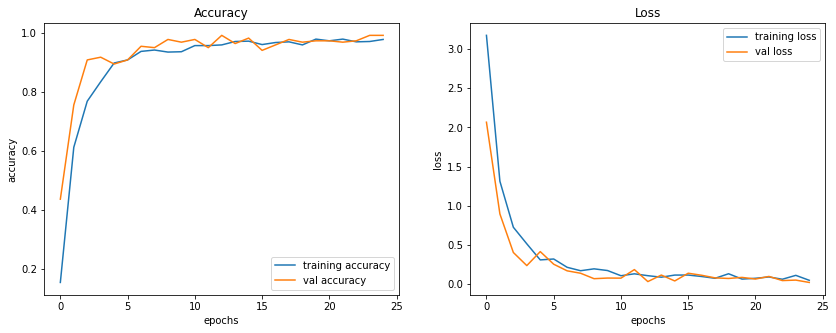

In [21]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14,5))
grid = GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

PGMN112


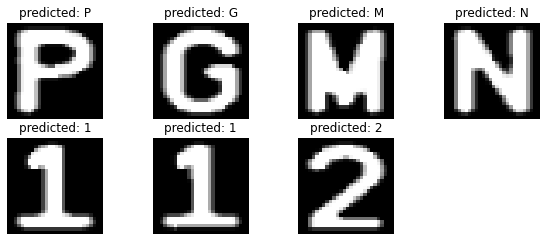

In [22]:
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(chars): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
#         img = fix_dimension(img_)
        img = np.zeros((28,28,3))
        for i in range(3):
            img[:,:,i] = img_
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model_char.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

licensePlateNumber = show_results()
print(licensePlateNumber)

# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(chars):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {licensePlateNumber[i]}')
    plt.axis('off')
plt.show()